# Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import zscore
import scipy.stats as stats
from scipy.stats import chi2_contingency
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
from mlxtend.evaluate import permutation_test
import statsmodels.api as sm

In [3]:
df_cat = pd.read_csv('./data/data_categorielles (1).csv')
df_num = pd.read_csv('./data/var_num.csv')
df_app = pd.read_csv('./data/application_train_vf.csv')

In [4]:
df2 = df_app[['WALLSMATERIAL_MODE',
'HOUSETYPE_MODE',
'EMERGENCYSTATE_MODE',
'OCCUPATION_TYPE','OWN_CAR_AGE',
'EXT_SOURCE_1',
'YEARS_BEGINEXPLUATATION_MEDI',
'YEARS_BEGINEXPLUATATION_MODE',
'YEARS_BEGINEXPLUATATION_AVG']]

# Preprocessing

In [5]:
data = pd.concat([df_num,df_cat,df2],axis = 1)

In [6]:
data['date'] = df_app['date_mensuelle'].copy()

In [7]:
data['date'] = pd.to_datetime(data['date'])

In [8]:
data.drop(columns = ['Unnamed: 0','NAME_HOUSING_TYPE','AMT_ANNUITY_disc_int'],inplace = True)
data['CODE_GENDER'] = data['CODE_GENDER'].apply(lambda x : 'F' if x == 'XNA' else x)

# Regroupement categories

In [9]:
list_mean = []
liste_freq = []

# Calcul des moyennes et des fréquences
for cat in data['OCCUPATION_TYPE'].unique():
    moyenne = data.loc[data['OCCUPATION_TYPE'] == cat, 'TARGET'].mean()
    freq = round(data[data['OCCUPATION_TYPE'] == cat].shape[0]/data.shape[0]*100,1)
    list_mean.append(moyenne)
    liste_freq.append(freq)
    
# Création du DataFrame CP
CP = pd.DataFrame({'mean': list_mean, 'freq': liste_freq, 'OCCUPATION_TYPE': data['OCCUPATION_TYPE'].unique()})
precaire = CP[CP['mean']>0.099]['OCCUPATION_TYPE']


data['OCCUPATION_TYPE'] = np.where(data['OCCUPATION_TYPE'].isin(precaire), 'Mauvais type', 'Bon type')


# Encoding

In [10]:
#data = data[['EXT_SOURCE_2_disc_int', 'EXT_SOURCE_3_disc_int', 'EXT_SOURCE_1','TARGET','date','SK_ID_CURR']]

In [11]:
for col in data.select_dtypes(include = 'object').columns:
    print(f"{col} : {data[col].nunique()}")

DAYS_BIRTH_disc_int : 3
EXT_SOURCE_2_disc_int : 3
AMT_GOODS_PRICE_disc_int : 2
REGION_POPULATION_RELATIVE_disc_int : 2
DAYS_EMPLOYED_disc_int : 2
DAYS_REGISTRATION_disc_int : 2
EXT_SOURCE_3_disc_int : 2
AMT_CREDIT_disc_int : 2
NAME_CONTRACT_TYPE : 2
CODE_GENDER : 2
FLAG_OWN_CAR : 2
FLAG_OWN_REALTY : 2
NAME_INCOME_TYPE_discret : 2
NAME_EDUCATION_TYPE_discret : 2
NAME_FAMILY_STATUS_discret : 2
WALLSMATERIAL_MODE : 7
HOUSETYPE_MODE : 3
EMERGENCYSTATE_MODE : 2
OCCUPATION_TYPE : 2


In [12]:
for col in data.columns:
    if data[col].dtype == 'object':
        mode = data[col].mode()[0]  
        data[col].fillna(mode, inplace=True)  
    elif data[col].dtype in ['int', 'float']:  
        moyenne = data[col].mean()  
        data[col].fillna(moyenne, inplace=True)

C:\Users\baheu\AppData\Local\Temp\ipykernel_15936\590291046.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(mode, inplace=True)
C:\Users\baheu\AppData\Local\Temp\ipykernel_15936\590291046.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doi

# Encoding

In [13]:
for col in data.select_dtypes(include = 'object').columns :
    print(f'{col} : {data[col].unique()}')

DAYS_BIRTH_disc_int : ['[-13537--7489]' '[-19303--13538]' '[-25229--19304]']
EXT_SOURCE_2_disc_int : ['[0.48-0.85]' '[0.0-0.15]' '[0.15-0.48]']
AMT_GOODS_PRICE_disc_int : ['[679500.0-4050000.0]' '[40500.0-676278.0]']
REGION_POPULATION_RELATIVE_disc_int : ['[0.0-0.03]' '[0.03-0.07]']
DAYS_EMPLOYED_disc_int : ['[-2443-365243]' '[-17912--2444]']
DAYS_REGISTRATION_disc_int : ['[-6170.0-0.0]' '[-24672.0--6171.0]']
EXT_SOURCE_3_disc_int : ['[0.32-0.9]' '[0.0-0.32]']
AMT_CREDIT_disc_int : ['[675000.0-4050000.0]' '[45000.0-674842.5]']
NAME_CONTRACT_TYPE : ['Cash loans' 'Revolving loans']
CODE_GENDER : ['M' 'F']
FLAG_OWN_CAR : ['Y' 'N']
FLAG_OWN_REALTY : ['Y' 'N']
NAME_INCOME_TYPE_discret : ['high_income' 'low_income']
NAME_EDUCATION_TYPE_discret : ['lower' 'higher']
NAME_FAMILY_STATUS_discret : ['couple' 'alone']
WALLSMATERIAL_MODE : ['Panel' 'Stone, brick' 'Block' 'Monolithic' 'Wooden' 'Mixed' 'Others']
HOUSETYPE_MODE : ['block of flats' 'specific housing' 'terraced house']
EMERGENCYSTATE_MOD

In [14]:
for col in data.select_dtypes(include='object').columns:
    one_hot_encoded = pd.get_dummies(data[col], prefix=col, drop_first=True)
    data = data.drop(col, axis=1)
    data = data.join(one_hot_encoded)

# Encoding boolean values as 1 for True and 0 for False
for col in data.select_dtypes(include=bool).columns:
    data[col] = data[col].astype(int)

# Train test split

In [15]:
X2 = data.drop(columns = ['SK_ID_CURR'], axis=1).copy()

# train
X_ech_0 = X2[X2['TARGET']==0].iloc[:20000,:]
X_ech_1 = X2[X2['TARGET']==1].iloc[:20000,:]
X_ech_train = pd.concat([X_ech_0,X_ech_1],axis=0)

# test
X_ech_0_test = X2[X2['TARGET']==0].iloc[20001:23000,:]
X_ech_1_test = X2[X2['TARGET']==1].iloc[20001:23000,:]
X_ech_test = pd.concat([X_ech_0_test,X_ech_1_test],axis=0)

# y test et train
y_ech_train = X_ech_train['TARGET'].copy()
y_ech_test = X_ech_test['TARGET'].copy()

# drop de target
X_ech_test.drop(columns=['TARGET','date'],inplace=True)
X_ech_train.drop(columns=['TARGET','date'],inplace=True)

In [16]:
X = data.drop(columns = ['TARGET', 'SK_ID_CURR'], axis=1).copy()
X = X[X['date']<'2020-01-01']
y = data[data['date']<'2020-01-01']['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
X.drop(columns='date',inplace=True)

In [17]:
X_train.drop(columns = ['date'],inplace = True)
X_test.drop(columns =['date'],inplace = True)

# Test avec fonction de perte customisée

In [25]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_auc_score


class_weight = {0: 1, 1: 1}  # Pénaliser plus fortement la classe 1 (positifs)



model = LogisticRegression(class_weight=class_weight,penalty='l2',max_iter=10000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice de confusion:")
print(conf_matrix)

auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print("AUC:", auc)


# Calculer le coefficient de Gini
gini_coefficient = 2 * auc - 1
print("Coefficient de Gini:", gini_coefficient)

Matrice de confusion:
[[49429    30]
 [ 4074    15]]
AUC: 0.7180685973566838
Coefficient de Gini: 0.43613719471336765


# LOGIT

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.24611226899478053
            Iterations: 292
            Function evaluations: 296
            Gradient evaluations: 292
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2459803503583517
            Iterations: 248
            Function evaluations: 251
            Gradient evaluations: 248
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.24652184957400003
            Iterations: 252
            Function evaluations: 255
            Gradient evaluations: 252
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.24591019786301813
            Iterations: 298
            Function evaluations: 301
            Gradient evaluations: 298
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.24576759580090124
            Iterations: 244
       

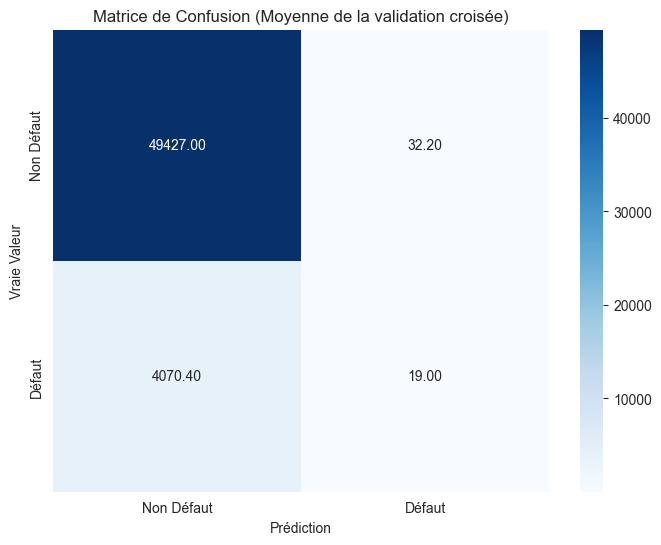

In [19]:
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

# Convert DataFrame to numpy arrays
X = X.values
y = y.values

# Define the number of folds for cross-validation
n_splits = 5

# Initialize StratifiedKFold with ensuring at least one positive instance in each fold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store confusion matrices from each fold
conf_matrices = []

# Iterate over folds
for train_index, test_index in skf.split(X, y):
    # Split data into train and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train_scaled = sm.add_constant(X_train)
    X_test_scaled = sm.add_constant(X_test)

    # Fit logistic regression model
    model = sm.Logit(y_train, X_train_scaled)
    result = model.fit_regularized(method='l1')

    # Predictions on testing set
    y_pred = result.predict(X_test_scaled)
    y_pred = (y_pred > 0.5).astype(int)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrices.append(conf_matrix)

# Average confusion matrix across folds
avg_conf_matrix = sum(conf_matrices) / n_splits

# Plot average confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(avg_conf_matrix, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=['Non Défaut', 'Défaut'], 
            yticklabels=['Non Défaut', 'Défaut'])
plt.xlabel('Prédiction')
plt.ylabel('Vraie Valeur')
plt.title('Matrice de Confusion (Moyenne de la validation croisée)')
plt.show()


# Résultats

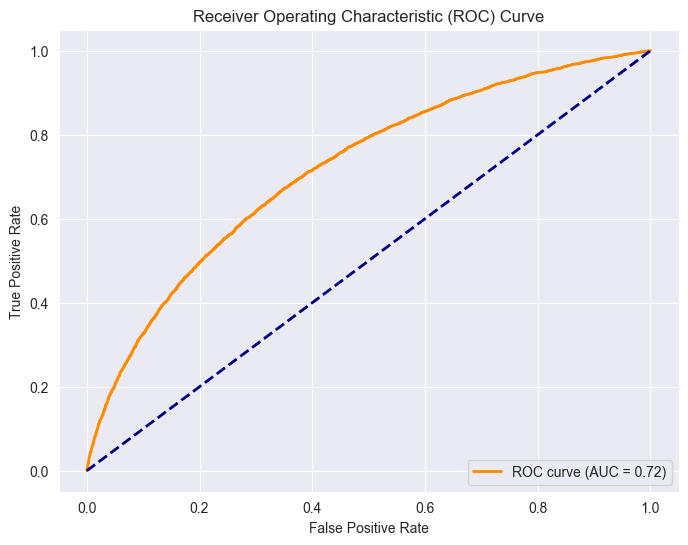

Coefficient de Gini: 0.43634019331030194


In [20]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

X_test_scaled = sm.add_constant(X_test)


y_prob = result.predict(X_test_scaled)


fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

y_prob = result.predict(X_test_scaled)

# Calculer le taux de faux positifs (FPR), le taux de vrais positifs (TPR) et les seuils
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculer l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

# Calculer le coefficient de Gini
gini_coefficient = 2 * roc_auc - 1
print("Coefficient de Gini:", gini_coefficient)


# Coefficients

In [21]:
coefficients = result.params
pvalues = result.pvalues

var_signif = [variable for variable, p_value in zip(X_test_scaled.columns, pvalues) if p_value < 0.05]

# Plot des coefficients avec des couleurs différentes en fonction des p-values (transposé)
colors = ['red' if p > 0.05 else 'green' for p in pvalues]

plt.figure(figsize=(15, 15))
plt.barh(range(len(coefficients)), coefficients, color=colors)
plt.yticks(range(len(coefficients)), X_test_scaled.columns)
plt.xlabel('Coefficients')
plt.title('Logistic Regression Coefficients with P-values (Transposed)')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
var_signif.pop(0)